## Drifters and Cmems data Notebook

### Introduction
This notebook aims to add the Ekman current components to the geostrophic components. Then, it extracts the inertial current components from drifter data using the spline smoothing filter with the functional approach of Ramsay and Silverman and linear Hanning filter at a 24-hour resolution.


### Data Sources
- Drifter Data:
  - Source: NOAA
  - Data Product: Global Drifter Program Current of NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 230
  - link : https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.html
  - period : 01-01-2022 to 01-01-2023

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 24 hours
  - Data Product:  SEALEVEL_GLO_PHY_L4_MY_008_047 and MULTIOBS_GLO_PHY_MYNRT_015_003
  - link : https://doi.org/10.48670/moi-00148 and https://doi.org/10.48670/mds-00327
  - download data : ahttps://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/download and https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_MYNRT_015_003/download
  - period : 01-01-2022 to 01-01-2023

### Tasks

#### 1. Interpolation CMEMS data

 - Interpolation of geostrophic and Ekman components (DUACS current) over the spatial and temporal grid of the drifter.

#### 2. Total CMEMS currents
 - Adding the surface Ekman current to the geostrophic current.
 -  Using the spline smoothing filter with the functional approach of Ramsay and Silverman at a 24-hour resolution to extract the inertial current components.
 -  conclusion

#### 1. Interpolation CMEMS data

## Import Library

In [33]:
import pandas as pd
import numpy as np
import xarray as xr
import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import interp2d

from scipy.signal import medfilt
from scipy.signal import hann, convolve

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data

In [34]:
fn='./drifter_6hour_qc_a65f_894f_fcdf_U1719475759871.nc';
ds=xr.open_dataset(fn);

C:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
C:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


## Extract Coordinates and Variables

In [35]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data

In [36]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)

## Selecting Drifter Data

In [37]:
# Test: Our selected drifter has 813 observations. 
 
df_1 = df[53965:54778]

# Arrange to begin with index 0

In [38]:
ve_curr_2 = df_1.ve.values
vn_curr_2 = df_1.vn.values
sst_2 = df_1.sst.values
lon_2 = df_1.longitude.values
lat_2 = df_1.latitude.values
time_2 = df_1.time.values

In [39]:
data = {
    'longitude': lon_2,
    'latitude' : lat_2,
    'time'     : time_2,
    've'       : ve_curr_2,
    'vn'       : vn_curr_2,
    'sst'      : sst_2
}

df_2 = pd.DataFrame(data)

## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity ugosa and  vgosa

In [40]:
# Loading drifting buoy data from the DataFrame
df_bouees = df_2 
 
# Loading satellite data from the netCDF file
ds_satellitaires = xr.open_dataset('cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1719675910724.nc') 
 
# Extracting satellite current data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_u.append(courant)

satellitaires_courant_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_v.append(courant)

### Case of zonal and meridional ekman Component of 15m deep  current (ue) and (ve)

In [41]:
# Loading drifting buoy data from the DataFrame
df_bouees = df_2
 
# Loading satellite wind data from the netCDF file
ds_ek = xr.open_dataset('cmems_obs_mob_glo_phy-cur_my_0.25deg_P1D-m_1719676287157.nc')   
 
# Extracting satellite wind data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellite_ue = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_ek['ue'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_ue.append(courant)

satellite_ve = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_ek['ve'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_ve.append(courant)

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (CMEMS current) and conclusion.

## ugeos plus Ekman zonal current

In [42]:
# u_total = u_geostro + u_e_sat
u_total = [a + b for a, b in zip(satellitaires_courant_u, satellite_ue)]

## vgeos plus Ekman meridional current

In [43]:
# u_total = v_geostro + v_e_sat
v_total = [a + b for a, b in zip(satellitaires_courant_v, satellite_ve)]

## Creation of Pandas Array for CMEMS total current Data

In [44]:
data = {
     
    'u_total'       : u_total,
    'v_total'       : v_total
     
}

dF = pd.DataFrame(data)
dF = dF.astype({'u_total': 'float64', 'v_total': 'float64'})

## Comparison between (ve and u_total) and (vn and v_total)

## Using Regression and Correlation

## case of ve and u_total

Corrélation de Pearson: 0.8050234652046382
Valeur de p (p-value): 4.293743523342581e-186


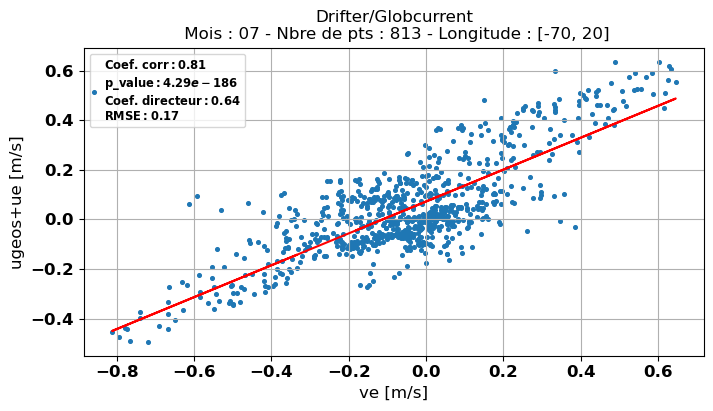

In [45]:
# According to the following, we can simply note that the correlation between "ve" and "ugeos + ue" is 0.81. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = df_2['ve']
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_u, dF['u_total'], 1)
p = np.poly1d(coefficients) # p = 0.64

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_u - dF['u_total'])**2)) # rmse = 0.17

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], s=7)
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]')
plt.ylabel('ugeos+ue [m/s]')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.81$' + '\n'
    r'$\text{p_value} : 4.29e-186$' + '\n'
    r'$\text{Coef. directeur} : 0.64$' + '\n'
    r'$\text{RMSE} : 0.17$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Mois : 07 - Nbre de pts : 813 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=12)
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig17 mode.png")
plt.show()

## case of vn and v_total

Corrélation de Pearson: 0.8375427604670649
Valeur de p (p-value): 4.2368397294123825e-215


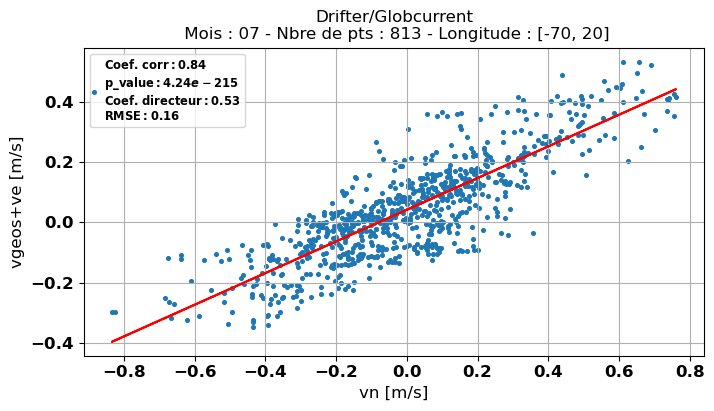

In [46]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.84. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = df_2['vn']
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_v, dF['v_total'], 1)
p = np.poly1d(coefficients) # p = 0.53

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_v - dF['v_total'])**2)) # rmse = 0.16

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], s=7)
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]')
plt.ylabel('vgeos+ve [m/s]')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.84$' + '\n'
    r'$\text{p_value} : 4.24e-215$' + '\n'
    r'$\text{Coef. directeur} : 0.53$' + '\n'
    r'$\text{RMSE} : 0.16$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Mois : 07 - Nbre de pts : 813 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=12)
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig18 mode.png")
plt.show()

# Application of a nonlinear median filter.

## Case of ve and vn

In [47]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['ve'])   

# Apply a median filter with a window size of 3
ve_filter_med = medfilt(current_data, kernel_size=3)

In [48]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['vn'])   

# Apply a median filter with a window size of 3
vn_filter_med = medfilt(current_data, kernel_size=3)

## Comparison between (ve_filter_cl and u_total) and (vn_filter_cl and v_total)

## Using Regression and Correlation

## Case of ve_filter_cl and u_total

Corrélation de Pearson: 0.8082414287888843
Valeur de p (p-value): 1.0327930039770906e-188


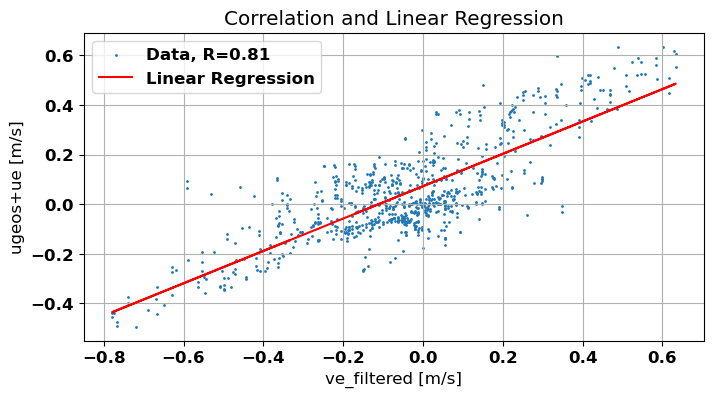

In [49]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos + ue" is 0.81. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = ve_filter_med
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_u, dF['u_total'], 1)
p = np.poly1d(coefficients) # p = 1.03

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_u - dF['u_total'])**2)) # rmse = 0.17

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], s=1, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve_filtered [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig19 mode.png")
plt.show()

## Case of vn_filter_med and v_total

Corrélation de Pearson: 0.8423684656903678
Valeur de p (p-value): 5.970638945887236e-220


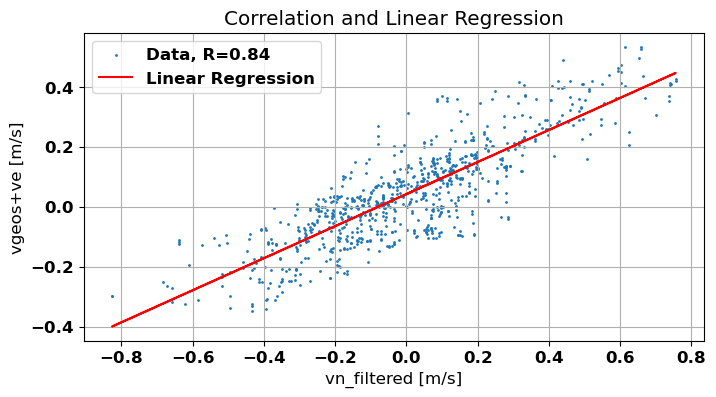

In [50]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos + ue" is 0.84. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = vn_filter_med
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_v, dF['v_total'], 1)
p = np.poly1d(coefficients) # p = 1.03

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_v - dF['v_total'])**2)) # rmse = 0.17

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], s=1, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn_filtered [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig20 mode.png")
plt.show()

# Application of a linear Hanning filter at a 24-hour resolution.

## Case of ve

In [51]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['ve'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
ve_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_5652\1390957898.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Case of vn

In [52]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['vn'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
vn_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_5652\2578851579.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Comparison between (ve_filter_Han and u_total) and (vn_filter_Han and v_total) 

## Using Regression and Correlation

## Case of ve_filter_Han and u_total

Corrélation de Pearson: 0.806125678910786
Valeur de p (p-value): 5.512949097962881e-187


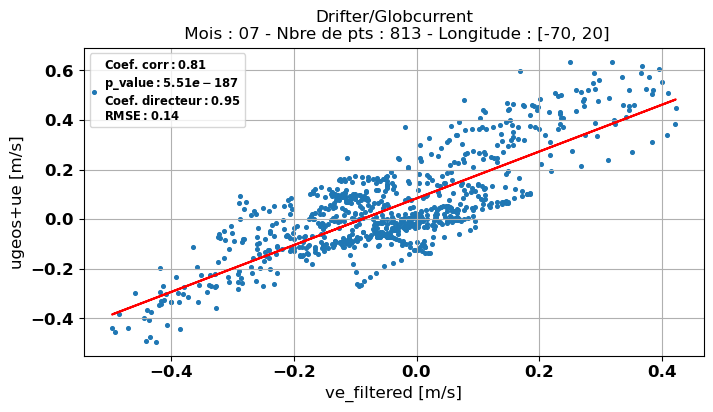

In [53]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos + ue" is 0.81. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = ve_filter_Han
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_u, dF['u_total'], 1)
p = np.poly1d(coefficients) # p = 0.95

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_u - dF['u_total'])**2)) # rmse = 0.14

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], s=7)
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve_filtered [m/s]')
plt.ylabel('ugeos+ue [m/s]')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.81$' + '\n'
    r'$\text{p_value} : 5.51e-187$' + '\n'
    r'$\text{Coef. directeur} : 0.95$' + '\n'
    r'$\text{RMSE} : 0.14$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Mois : 07 - Nbre de pts : 813 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=12)
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig21 mode.png")
plt.show()

## Case of vn_filter_Han and v_total

Corrélation de Pearson: 0.8672929090875027
Valeur de p (p-value): 6.5943373165179425e-248


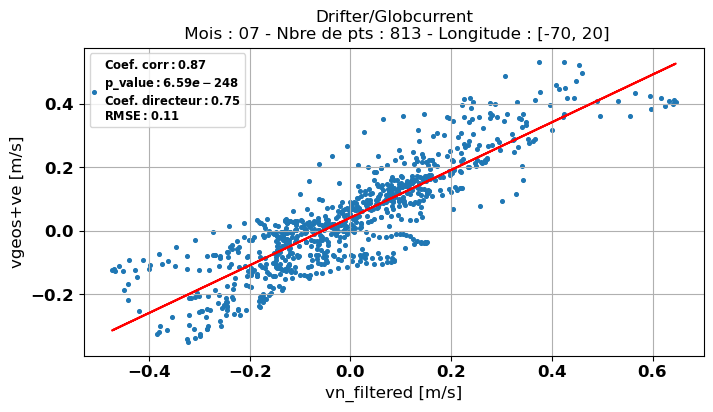

In [54]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.84. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = vn_filter_Han
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_v, dF['v_total'], 1)
p = np.poly1d(coefficients) # p = 0.75

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_v - dF['v_total'])**2)) # rmse = 0.11

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], s=7)
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn_filtered [m/s]')
plt.ylabel('vgeos+ve [m/s]')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.87$' + '\n'
    r'$\text{p_value} : 6.59e-248$' + '\n'
    r'$\text{Coef. directeur} : 0.75$' + '\n'
    r'$\text{RMSE} : 0.11$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Mois : 07 - Nbre de pts : 813 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=12)
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig22 mode.png")
plt.show()

## Application of Clement filter 

## Case of ve and vn

In [55]:
filenc = './drifter_6hour_qc_a65f_894f_fcdf_U1719475759871.nc'

with Dataset(filenc, 'r') as fcid:
    time = numpy.array(fcid.variables['time']) # seconds
    u = numpy.array(fcid.variables['ve'])
    v = numpy.array(fcid.variables['vn'])
    lat = numpy.array(fcid.variables['latitude'])

U = u + 1j*v

dt=time[1]-time[0]
fc = 2*2*numpy.pi/86164*numpy.sin(lat.mean()*numpy.pi/180)  # s-1

time_conv = numpy.arange(-3*86400,3*86400+dt,dt)

taul=3*fc**-1
# gl = (numpy.exp(-1j*numpy.outer(fc[:],time_conv))*numpy.exp(-numpy.outer(taul**-2,time_conv**2))).reshape(len(time),len(time_conv))
gl = numpy.exp(-1j*fc*time_conv)*numpy.exp(-taul**-2*time_conv**2)
gl = (gl.T / numpy.sum(numpy.abs(gl), axis=0).T).T

Unio =numpy.convolve(U,gl,'same')

u_nio = numpy.real(Unio)
v_nio = numpy.imag(Unio)

## Comparison between (ve_filter_cl and u_total) and (vn_filter_cl and v_total) 

## Case of ve_filter_cl and u_total

Corrélation de Pearson: -0.003454542970687265
Valeur de p (p-value): 0.9216554405365146


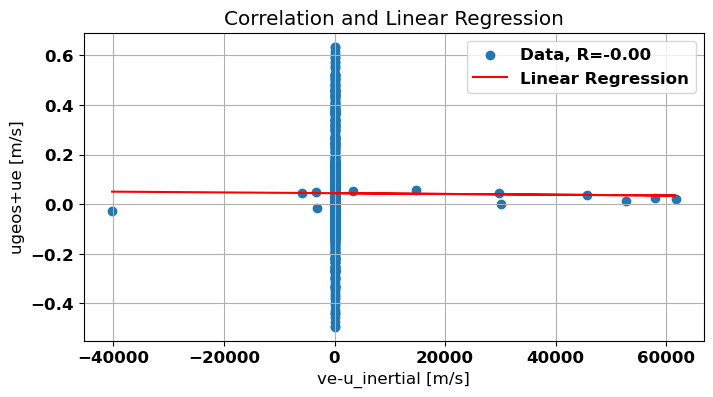

In [56]:
# According to the following, we can simply note that the correlation between "ve_filter_cl" and "ugeos + ue" is 0.83. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u =  u_nio[53965:54778]
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_u, dF['u_total'], 1)
p = np.poly1d(coefficients) # p = 0.75

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_u - dF['u_total'])**2)) # rmse = 0.11

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-u_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig23 mode.png")
plt.show()

## Case of vn_filter_cl and v_total

Corrélation de Pearson: -0.025628338495160954
Valeur de p (p-value): 0.46554893146276366


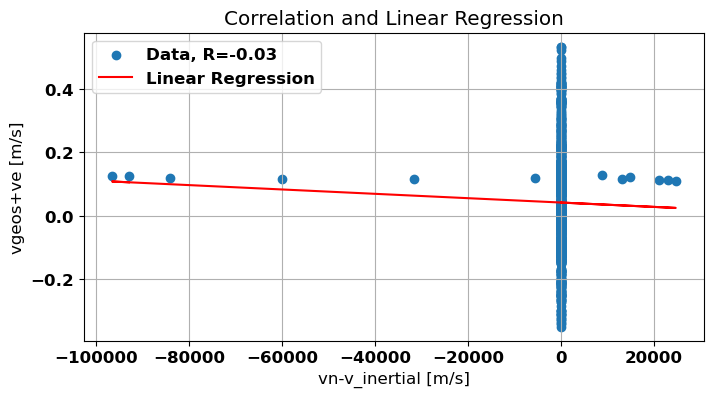

In [57]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.83. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = v_nio[53965:54778]
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Calcul de la régression linéaire
coefficients = np.polyfit(bouees_courant_v, dF['v_total'], 1)
p = np.poly1d(coefficients) # p = 0.75

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((bouees_courant_v - dF['v_total'])**2)) # rmse = 0.11

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig24 mode.png")
plt.show()

### Resume

### Zonal components currents

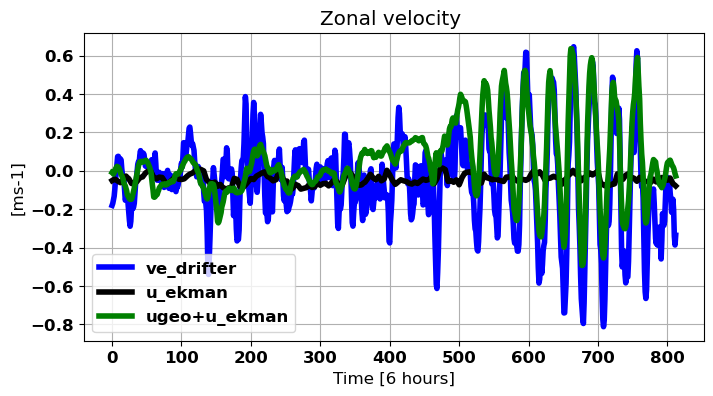

In [58]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(df_2['ve'], color='blue',label='ve_drifter', linewidth=4)
# plt.plot(satellitaires_courant_u, color='red',label='ugeo', linewidth=4)
plt.plot(satellite_ue, color='k',label='u_ekman',  linewidth=4)
plt.plot(dF['u_total'], color='g',label='ugeo+u_ekman',  linewidth=4)

plt.title('Zonal velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig25 mode.png")
plt.show()

### Meridional components currents

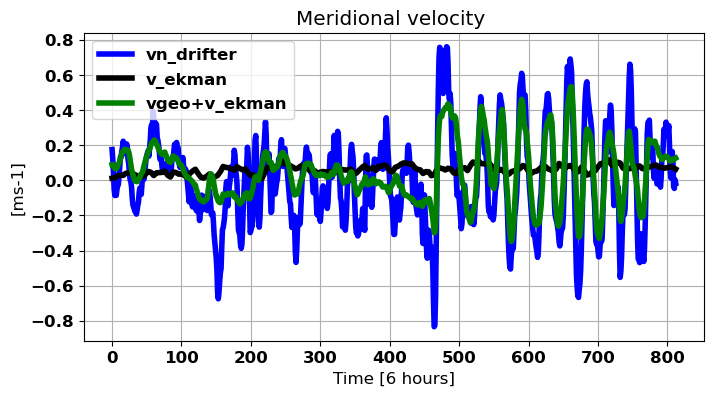

In [59]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(df_2['vn'], color='blue',label='vn_drifter',  linewidth=4)
# plt.plot(satellitaires_courant_v, color='red',label='vgeo',  linewidth=4)
plt.plot(satellite_ve, color='k',label='v_ekman',  linewidth=4)
plt.plot(dF['v_total'], color='g',label='vgeo+v_ekman',  linewidth=4)

plt.title('Meridional velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig26 mode.png")
plt.show()

# Application of a linear Hanning filter at a 24-hour resolution.

### Zonal components currents

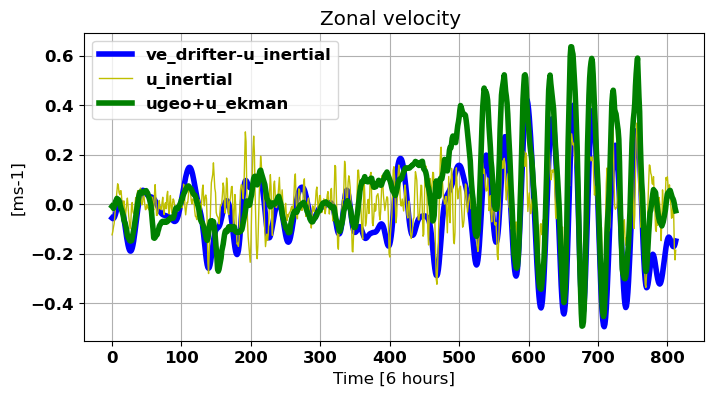

In [60]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(ve_filter_Han, color='blue',label='ve_drifter-u_inertial',  linewidth=4)
# plt.plot(satellitaires_courant_u, color='red',label='ugeo',  linewidth=4)
# plt.plot(satellite_ue, color='k',label='u_ekman',  linewidth=4)
plt.plot(df_2['ve']-ve_filter_Han, color='y',label='u_inertial',  linewidth=1)
plt.plot(dF['u_total'], color='g',label='ugeo+u_ekman',  linewidth=4)

plt.title('Zonal velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig27 mode.png")
plt.show()

### Meridional components currents

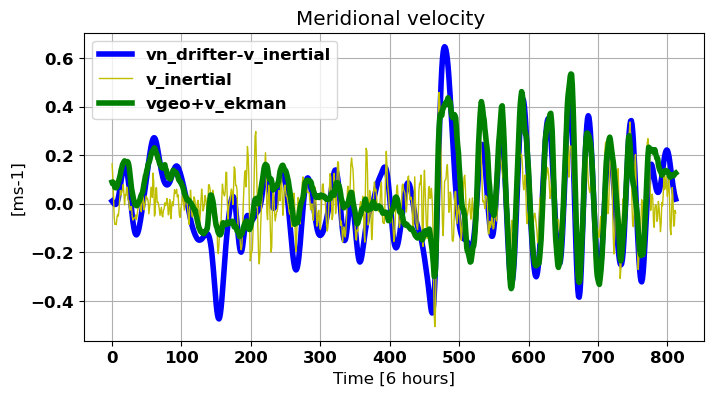

In [61]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(vn_filter_Han, color='blue',label='vn_drifter-v_inertial',  linewidth=4)
# plt.plot(satellitaires_courant_v, color='red',label='vgeo',  linewidth=4)
# plt.plot(satellite_ve, color='k',label='v_ekman',  linewidth=4)
plt.plot(df_2['vn']-vn_filter_Han, color='y',label='v_inertial',  linewidth=1)
plt.plot(dF['v_total'], color='g',label='vgeo+v_ekman',  linewidth=4)

plt.title('Meridional velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig28 mode.png")
plt.show()

## Summarize

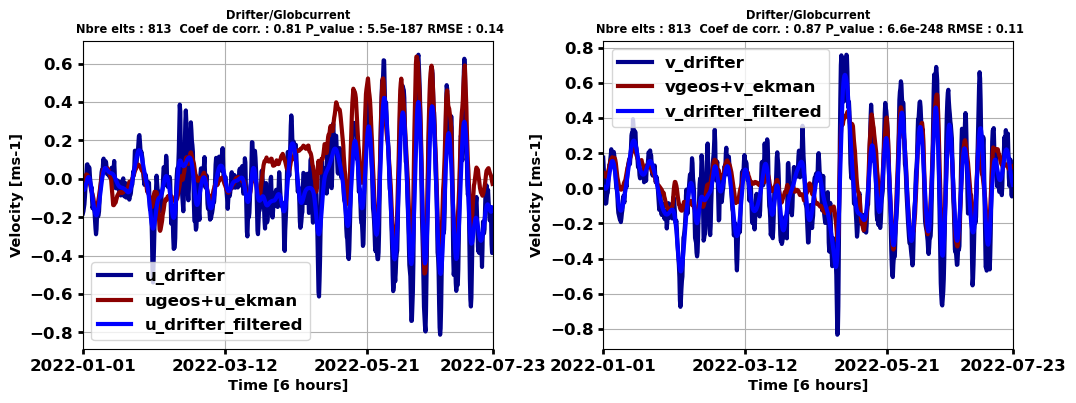

In [62]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique

plt.plot(df_2['time'], df_2['ve'], color='#00008B', label='u_drifter',  linewidth=3)
plt.plot(df_2['time'], dF['u_total'], color='#8B0000',label='ugeos+u_ekman',  linewidth=3)
plt.plot(df_2['time'], ve_filter_Han, color='blue',label='u_drifter_filtered',  linewidth=3)

plt.title('Zonal velocity ', fontsize=10.5, fontweight='bold')
plt.xlabel('Time [6 hours]', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [ms-1]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()
# Configurer l'axe x
ax = plt.gca()
# Définir les limites de l'axe x en utilisant les dates min et max du DataFrame
min_date = df_2['time'].min()
max_date = df_2['time'].max()
ax.set_xlim(min_date, max_date)

# Ajouter les ticks de l'axe x avec une fréquence de 840 heures (35 jours)
# Assurez-vous que les ticks couvrent toute la période des données
xticks = pd.date_range(start=min_date, end=max_date, freq='1690H')
if xticks[-1] < max_date:  # Vérifier si la dernière tick est avant la date de fin
    xticks = xticks.append(pd.DatetimeIndex([max_date]))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime('%Y-%m-%d'), rotation=0)

# Ajuster les paramètres de la police
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
  
# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 813  Coef de corr. : 0.81 P_value : 5.5e-187 RMSE : 0.14'
plt.title(title_text, fontsize=8.2, fontweight='bold')

plt.subplot(1, 2, 2)  # Premier sous-graphique

plt.plot(df_2['time'], df_2['vn'], color='#00008B', label='v_drifter',  linewidth=3)
plt.plot(df_2['time'], dF['v_total'], color='#8B0000',label='vgeos+v_ekman',  linewidth=3)
plt.plot(df_2['time'], vn_filter_Han, color='blue',label='v_drifter_filtered',  linewidth=3)

plt.title('Meridional velocity ', fontsize=10.5, fontweight='bold')
plt.xlabel('Time [6 hours]', fontsize=10.5, fontweight='bold')
plt.ylabel('Velocity [ms-1]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.legend()
# Configurer l'axe x
ax = plt.gca()
# Définir les limites de l'axe x en utilisant les dates min et max du DataFrame
min_date = df_2['time'].min()
max_date = df_2['time'].max()
ax.set_xlim(min_date, max_date)

# Ajouter les ticks de l'axe x avec une fréquence de 840 heures (35 jours)
# Assurez-vous que les ticks couvrent toute la période des données
xticks = pd.date_range(start=min_date, end=max_date, freq='1690H')
if xticks[-1] < max_date:  # Vérifier si la dernière tick est avant la date de fin
    xticks = xticks.append(pd.DatetimeIndex([max_date]))

ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime('%Y-%m-%d'), rotation=0)

# Ajuster les paramètres de la police
ax.tick_params(axis='both', which='major', labelsize=12, width=2)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

# Titre
title_text = 'Drifter/Globcurrent\n Nbre elts : 813  Coef de corr. : 0.87 P_value : 6.6e-248 RMSE : 0.11'
plt.title(title_text, fontsize=8.2, fontweight='bold')

plt.subplots_adjust( wspace=0.27)  # Ajuster hspace et wspace si nécessaire
plt.savefig("fig29 mode.png")

## Conclusion
-  Strong correlation between drifter currents and altimetry currents (CMEMS Current).
-  Total altimetric zonal component slightly dominated by the total meridional component.